# Advanced Machine Learning - Project 2
## Caenorhabditis elegans roundworms exploration

- Eduardo Carneiro - 62515
- Til Dietrich - 62928


## Todo List
- Classification (KNN with different metrics, Different data representations like PAA and SAX into KNN, Summarization methods into KNN, etc) (maybe search for other classifiers other than KNN for time series)
- Til: work on ARIMA

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from scipy.stats import mode
from scipy import signal

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [4]:
# general parameters
sns.set(style='whitegrid', palette='muted', context='paper')
random_state = 42


In [5]:
# defining some general functions for this notebook

# function to create a differences time series (taken from class notebook), default is first difference
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return np.array(diff)

In [6]:
# read data, split into X and y
df_train = pd.read_csv("../worms_trainset.csv")
y_train = df_train.iloc[:,0]
X_train = df_train.drop(columns=[ df_train.columns[0] ])

df_test = pd.read_csv("../worms_testset.csv")
y_test = df_test.iloc[:,0]
X_test = df_test.drop(columns=[ df_test.columns[0] ])

## Structure
### 1. Data exploration and transformations
### 2. Models
#### 2.1. Classification
#### 2.2. ARIMA
### 3. Discussion and Conclusion

## 1. Data exploration

In [6]:
# check shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((180, 900), (180,), (76, 900), (76,))

The dataset consists of 256 univariate time series with 900 observations (time points) each.
In total, there are 256 worm traces. These time series are split 70%/30% into train and test set with 180 and 76 observations, respectively.

In [7]:
# check for nulls
print("Nulls in train set: ", df_train.isnull().sum().sum())

Nulls in train set:  0


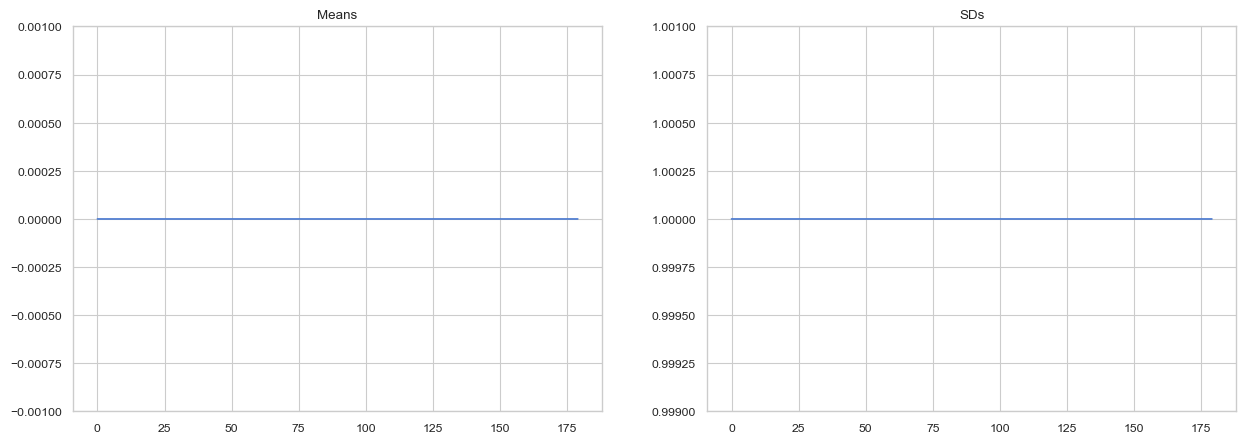

In [8]:
# normalize data if necessary
# calculate mean and std for each time series
means = X_train.mean(axis=1)
sds = X_train.std(axis=1)

# plot means and stds
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(means)
plt.title("Means")
plt.ylim(-0.001, 0.001)
plt.subplot(1,2,2)
plt.plot(sds)
plt.title("SDs")
plt.ylim(0.999, 1.001)
plt.show()

There is no need to normalize the data as they are already normalized to follow a normal distribution with 0 mean and a standard deviation of 1.

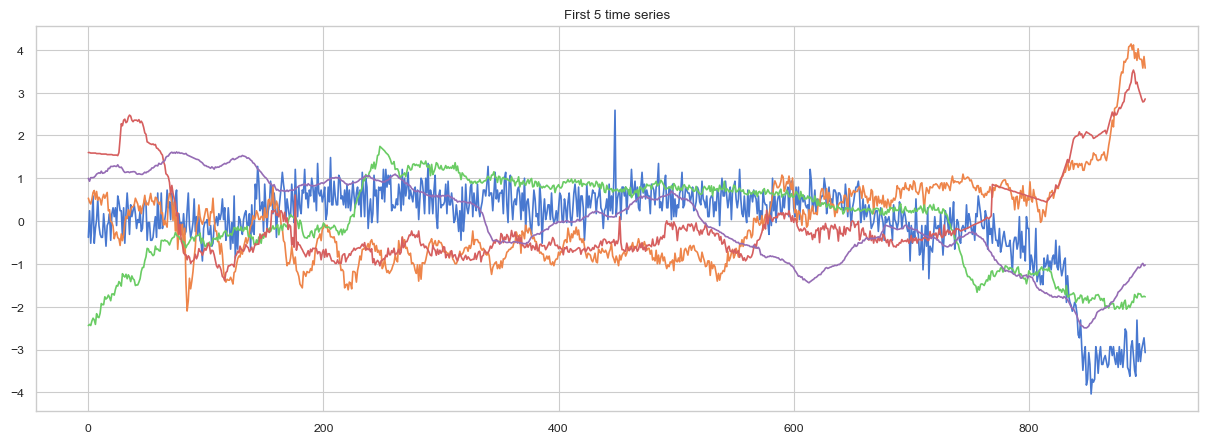

In [9]:
# plot first X time series in one graph
n_series = 5

plt.figure(figsize=(15,5))
for i in range(n_series):
    plt.plot( range(0,900),X_train.iloc[i,:])
plt.title("First 5 time series")
plt.show()


# Noise Removal
As it can be seen in the graph before, there is some noise in the data (outliers).
To smooth the data and try to mitigate this noise, we will use a moving average filter.

## Questions
- SHOULD WE DO MOVING AVERAGE ON THE TEST SET TOO???!?!?!?!?!?!?!?

In [12]:
# Moving-Average Smoothing
n = 900
window_size = 5

X_train_mov_avg = np.array([X_train.iloc[i,:].rolling(window_size).mean() for i in range( X_train.iloc[:n,:].shape[0] )])[:,window_size:]
X_test_mov_avg = np.array([X_test.iloc[i,:].rolling(window_size).mean() for i in range( X_test.iloc[:n,:].shape[0] )])[:,window_size:]

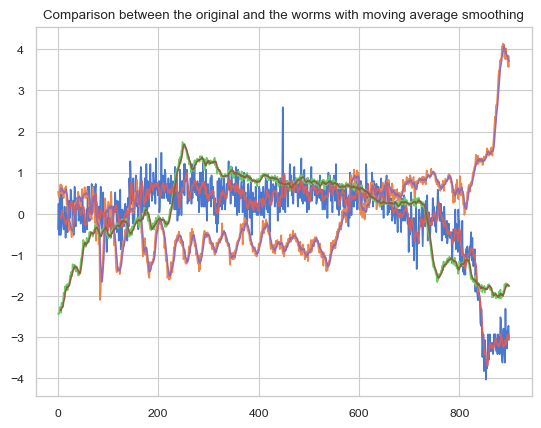

In [13]:
n_series = 3

plt.title("Comparison between the original and the worms with moving average smoothing")
for i in range(n_series):
    plt.plot( range(0, 900),X_train.iloc[i,:])

for i in range(n_series):
    plt.plot( range(window_size, 900), X_train_mov_avg[i] )
plt.show()


# Representation
In order to evalute if the representation of the data has an impact on the classification, we will try different representations and compare the results.
We decided in using the following representations:
- Original data
- Moving average
- PAA over Moving average
- SAX over Moving average
- Statistical Feature Space over Moving average
- DFT over Moving average (as the worms behave like waves, DFT might be a good representation given the fact that it gets the fundamental frequencies of the signal)

### PAA

In [14]:
n_seg = 550
paa = PiecewiseAggregateApproximation(n_segments= n_seg)

X_train_paa = paa.fit_transform( X_train_mov_avg ).reshape(180,n_seg)
# df_train_paa = pd.DataFrame(df_train_paa).dropna(axis=1)

X_test_paa = paa.fit_transform( X_test_mov_avg ).reshape(76,n_seg)
# df_test_paa = pd.DataFrame(df_test_paa).dropna(axis=1)

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 180 1-dimensional timeseries
  warnings.warn(
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


### Summarization Methods
- This is a really basic summarization method, but it might be useful to reduce the size of the dataset
- We can further extend the summarization method to include more features, like other statistical measures

In [15]:
ft_space_train = [ [np.mean(i), np.median(i), mode(i).mode, np.var(i)] for i in X_train_mov_avg ]
ft_space_test = [ [np.mean(i), np.median(i), mode(i).mode, np.var(i)] for i in X_train_mov_avg ]

### DFT

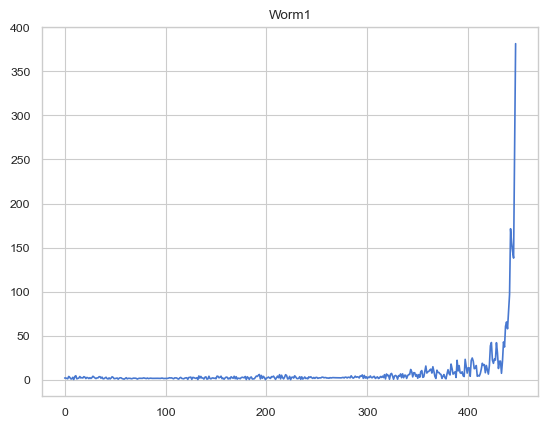

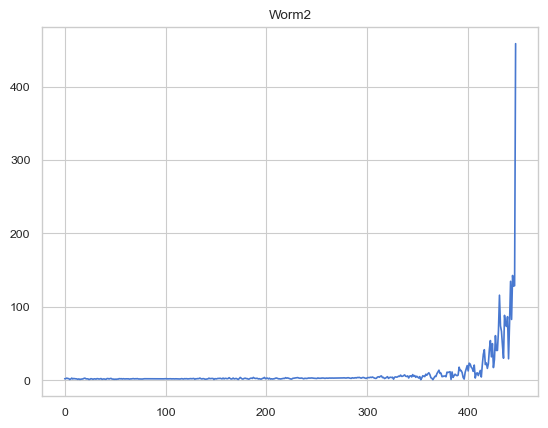

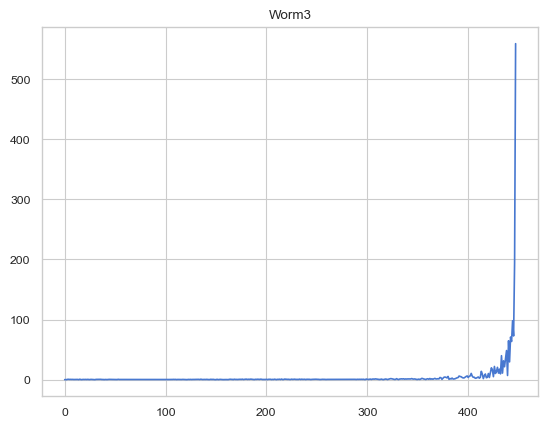

In [16]:
dfts_train = np.fft.fft(X_train_mov_avg)
dfts_test = np.fft.fft(X_test_mov_avg)

# Why this? Because the DFT returns complex values and KNN does not support complex values
# We convert a complex value into a tuple with the real and imaginary part as floats
dfts_train_fin = []
for worm in dfts_train:
    temp = []
    for complex_val in worm:
        temp.append([complex_val.real, complex_val.imag])
    dfts_train_fin.append(temp)

dfts_test_fin = []
for worm in dfts_test:
    temp = []
    for complex_val in worm:
        temp.append([complex_val.real, complex_val.imag])
    dfts_test_fin.append(temp)


half = int(len(dfts_train[0])/2)

# plot the dft
plt.title("Worm1")
plt.plot(abs(dfts_train[0][half:]))
plt.show()

# plot the dft
plt.title("Worm2")
plt.plot(abs(dfts_train[1][half:]))
plt.show()

# plot the dft
plt.title("Worm3")
plt.plot(abs(dfts_train[2][half:]))
plt.show()

### Discrete Wavelet Transform

## 2.1. Classification
In order to classify each worm trace, we used various classifiers:
- KNN with different metrics (Euclidean, DTW)
- Random Forest Classifier
- Logistic Regression Classifier
- Hidden Markov Model (HMM)
- K-Means Clustering

In each classifier, we did some Grid Search to find the best hyper-parameters for each classifier, and also tested each of these classifier with different data representations.

## KNN
- Just some tests to see how the KNN performs on the original raw data with some metrics


In [17]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        print(f"{metric}:knn{neigh_num}|{accuracy_score(y_test, y_pred)}")

euclidean:knn1|0.6052631578947368
euclidean:knn3|0.5394736842105263
euclidean:knn5|0.5
euclidean:knn7|0.5131578947368421
euclidean:knn9|0.5526315789473685
dtw:knn1|0.618421052631579
dtw:knn3|0.5526315789473685
dtw:knn5|0.5394736842105263
dtw:knn7|0.5657894736842105
dtw:knn9|0.5921052631578947


- Observing KNN performance with smoothed data from moving average

In [18]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(X_train_mov_avg, y_train)

        y_pred = knn.predict(X_test_mov_avg)
        print(f"{metric}:knn{neigh_num}|{accuracy_score(y_test, y_pred)}")

euclidean:knn1|0.5789473684210527
euclidean:knn3|0.5263157894736842
euclidean:knn5|0.4868421052631579
euclidean:knn7|0.5131578947368421
euclidean:knn9|0.5394736842105263
dtw:knn1|0.618421052631579
dtw:knn3|0.618421052631579
dtw:knn5|0.5789473684210527
dtw:knn7|0.5526315789473685
dtw:knn9|0.618421052631579


- Observing KNN performance with PAA representation

In [19]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn_paa = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)
        knn_paa.fit( X_train_paa, y_train)

        y_pred = knn_paa.predict(X_test_paa)
        # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
        # This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
        print(f"PAA|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")



PAA|euclidean:knn1|acc:0.6578947368421053|f1:0.6561780796076211
PAA|euclidean:knn3|acc:0.631578947368421|f1:0.6206140350877193
PAA|euclidean:knn5|acc:0.6578947368421053|f1:0.6436726737478617
PAA|euclidean:knn7|acc:0.6710526315789473|f1:0.6551914377137814
PAA|euclidean:knn9|acc:0.6447368421052632|f1:0.6092465205567109
PAA|dtw:knn1|acc:0.618421052631579|f1:0.6191632928475034
PAA|dtw:knn3|acc:0.5526315789473685|f1:0.5542079299729239
PAA|dtw:knn5|acc:0.5789473684210527|f1:0.5768345595170722
PAA|dtw:knn7|acc:0.5657894736842105|f1:0.5590630485453656
PAA|dtw:knn9|acc:0.6052631578947368|f1:0.6032823995472553


- Observing KNN performance with SAX representation

In [20]:
for n_seg in [250, 350, 450, 550, 650]:
    for alph_size in [10, 20, 30, 40]:
        for neigh_num in [1,3,5]:
            knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= "sax", metric_params={"n_segments": n_seg, "alphabet_size_avg": alph_size})
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            print(f"SAX|knn{neigh_num}|n_seg:{n_seg}:alph_size:{alph_size}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

SAX|knn1|n_seg:250:alph_size:10|acc:0.6052631578947368|f1:0.6074745687748785
SAX|knn3|n_seg:250:alph_size:10|acc:0.5394736842105263|f1:0.5323395969420543
SAX|knn5|n_seg:250:alph_size:10|acc:0.5394736842105263|f1:0.5323395969420543
SAX|knn1|n_seg:250:alph_size:20|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:20|acc:0.5131578947368421|f1:0.5141048908744008
SAX|knn5|n_seg:250:alph_size:20|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:250:alph_size:30|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:30|acc:0.5394736842105263|f1:0.5384059399434916
SAX|knn5|n_seg:250:alph_size:30|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:250:alph_size:40|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:40|acc:0.5263157894736842|f1:0.5208237986270023
SAX|knn5|n_seg:250:alph_size:40|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:350:alph_size:10|acc:0.6052631578947368|f1:0.6066540558584622

- Observing KNN performance with summarization methods representation

In [21]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(ft_space_train, y_train)

        y_pred = knn.predict(ft_space_test)
        print(f"feature_space|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

ValueError: Found input variables with inconsistent numbers of samples: [76, 180]

- Observing KNN performance with DFT representation

In [ ]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(dfts_train_fin, y_train)

        y_pred = knn.predict(dfts_test_fin)
        print(f"DFT|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

DFT|euclidean:knn1|acc:0.5789473684210527|f1:0.5789473684210527
DFT|euclidean:knn3|acc:0.5263157894736842|f1:0.5169324632196779
DFT|euclidean:knn5|acc:0.4868421052631579|f1:0.48565233307989075
DFT|euclidean:knn7|acc:0.5131578947368421|f1:0.5012003693444137
DFT|euclidean:knn9|acc:0.5394736842105263|f1:0.5172680127992938
DFT|dtw:knn1|acc:0.5394736842105263|f1:0.5231588812706556
DFT|dtw:knn3|acc:0.5789473684210527|f1:0.5706066339730471
DFT|dtw:knn5|acc:0.631578947368421|f1:0.6242808047264162
DFT|dtw:knn7|acc:0.6447368421052632|f1:0.6392334033552991
DFT|dtw:knn9|acc:0.6578947368421053|f1:0.6477130325814535


## Random Forest

In [ ]:

# print(np.reshape(dfts_train_fin, (180,895*2))[0,:4])
print(np.reshape(dfts_test_fin, (76,895*2)).shape)

(76, 1790)


In [ ]:
for tree_num in [100, 200, 250, 300]:
    for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, ft_space_train, dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        rfc = RandomForestClassifier(n_estimators=tree_num)

        if name == "dft":
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        rfc.fit(rep_train, y_train)
        y_pred = rfc.predict(rep_test)

        print(f"RFC|tree_num:{tree_num}|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

RFC|tree_num:100|mov_avg|acc:0.6578947368421053|f1:0.6511178901031008
RFC|tree_num:100|paa|acc:0.631578947368421|f1:0.631578947368421
RFC|tree_num:100|ft_space|acc:0.6578947368421053|f1:0.6578947368421053
RFC|tree_num:100|dft|acc:0.618421052631579|f1:0.6202301187560648
RFC|tree_num:200|mov_avg|acc:0.6842105263157895|f1:0.6826259196378042
RFC|tree_num:200|paa|acc:0.5921052631578947|f1:0.5911595468070927
RFC|tree_num:200|ft_space|acc:0.6973684210526315|f1:0.694915093534593
RFC|tree_num:200|dft|acc:0.618421052631579|f1:0.612509951751988
RFC|tree_num:250|mov_avg|acc:0.6578947368421053|f1:0.6539282990083906
RFC|tree_num:250|paa|acc:0.6052631578947368|f1:0.6052631578947368
RFC|tree_num:250|ft_space|acc:0.6578947368421053|f1:0.6561780796076211
RFC|tree_num:250|dft|acc:0.6052631578947368|f1:0.6032823995472553
RFC|tree_num:300|mov_avg|acc:0.631578947368421|f1:0.6206140350877193
RFC|tree_num:300|paa|acc:0.631578947368421|f1:0.6297302395774382
RFC|tree_num:300|ft_space|acc:0.6578947368421053|f1:0

## Logistic regression classifier

In [ ]:
for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, ft_space_train, dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
    lrc = LogisticRegression(random_state=0, max_iter=2200)

    if name == "dft":
        rep_train = np.reshape(rep_train, (180,895*2))
        rep_test = np.reshape(rep_test, (76,895*2))

    lrc.fit(rep_train, y_train)
    y_pred = lrc.predict(rep_test)

    print(f"LRC|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

LRC|mov_avg|acc:0.5131578947368421|f1:0.5161331826160477
LRC|paa|acc:0.5131578947368421|f1:0.5154660135853241
LRC|ft_space|acc:0.5921052631578947|f1:0.4536474877032152
LRC|dft|acc:0.5921052631578947|f1:0.5945980719215535


## HMM

In [ ]:
from hmmlearn import hmm


for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, ft_space_train, dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
   
    # Define the Hidden Markov Model

    model = hmm.GaussianHMM(n_components=2, covariance_type="diag", random_state=8)

    if name == "dft":
        rep_train = np.reshape(rep_train, (180,895*2))
        rep_test = np.reshape(rep_test, (76,895*2))
    
    # Train the model on the data
    model.fit(rep_train)

    y_pred = model.predict(rep_test)

    print(f"HMM:{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

HMM:mov_avg|acc:0.17105263157894737|f1:0.15639097744360905
HMM:paa|acc:0.2236842105263158|f1:0.21366849960722697
HMM:ft_space|acc:0.40789473684210525|f1:0.24627606752730882
HMM:dft|acc:0.15789473684210525|f1:0.16040100250626566


## K-Means

In [ ]:


for metric in ["euclidean","dtw" ]:
    for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, np.array(ft_space_train), dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        km = TimeSeriesKMeans(n_clusters=2, metric=metric, random_state=0)
       
        if name == "dft":
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        y_pred = km.fit_predict(rep_train)
        print(silhouette_score(rep_train,y_pred,metric=metric))

        # print(f"LRC|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

0.1141667463659055
0.13318981934344137
0.6103879984483321
0.1141667463659055
0.16834789446443849
0.17161459061788706
0.5461129889991868
0.1523812402989934


In [ ]:
for metric in ["euclidean"]:#,"dtw" ]:
    for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, np.array(ft_space_train), dfts_train_fin], [X_test_mov_avg, X_test_paa, np.array(ft_space_test), dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        km = TimeSeriesKMeans(n_clusters=2, metric=metric, random_state=0)
       
        if name == "dft":
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        y_pred = km.fit(rep_train).predict(rep_test)
        print(accuracy_score(y_test,y_pred),silhouette_score(rep_test,y_pred,metric=metric))

d:\OneDrive - Universidade de Coimbra\Mestrado\Files\1Semestre\AAA\P\P1\venv_AML\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(
d:\OneDrive - Universidade de Coimbra\Mestrado\Files\1Semestre\AAA\P\P1\venv_AML\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


0.25 0.08906706674604518
0.17105263157894737 0.11463678516025695


d:\OneDrive - Universidade de Coimbra\Mestrado\Files\1Semestre\AAA\P\P1\venv_AML\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


0.2631578947368421 0.644654659245818
0.25 0.08906706674604514


d:\OneDrive - Universidade de Coimbra\Mestrado\Files\1Semestre\AAA\P\P1\venv_AML\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


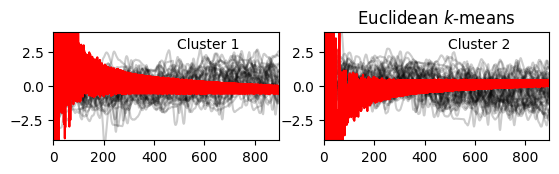

In [ ]:
import matplotlib.pyplot as plt

sz = X_test_mov_avg.shape[1]
plt.figure()
for yi in range(2):
    plt.subplot(3, 2, yi + 1)
    for xx in X_test_mov_avg[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

### 2.2.1 Classification Observations
After all the tests, we can conclude that the best classifier for this dataset is the **Random Forest Classifier** with the **DFT** representation.

As stated before, the worms behave like waves, so the DFT representation is a good representation to get the fundamental frequencies of the signal.

Nevertheless, the best accuracy is still only **68%**, which is, objectively, **not a very good** result.
This can be caused by several factors:
- The dataset is too small (only 256 samples, which have to be split into train and test set)
- The dataset is too noisy (applying moving average fixes some of the noise, but also removes some of the "unique" characteristics of each worm)

- NEED TO CHECK IF IT IS ANY OF THESES CASES ABOUT THIS: The worms are too different inside each class or very similar between classes (this is a problem that we cannot solve, as we cannot change the dataset) 

## 2.2. ARIMA modelling

In this section, we randomly extract one eigenworm (time series) and try to model it as closely as possible.
The final goal is to find a function that represents the underlying data generating process in a way that we are left with white noise residuals.
We will follow a number of steps:
1. Visual inspection to get a general idea of the underlying time series
2. Create baseline model for comparison
3. Check for stationarity and make time series stationary through data transformation in case it is not
4. Inspect the Autcorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the stationary time series to identify possible models.
5. Test different specifications of an ARIMA model

In [7]:
# choose one eigenworm (time series) with index 5 (need to use 4 to get the 5th time series)
X = X_train.iloc[4,:]
X = X.values
X = X.astype('float32')

### 1. Visual inspection

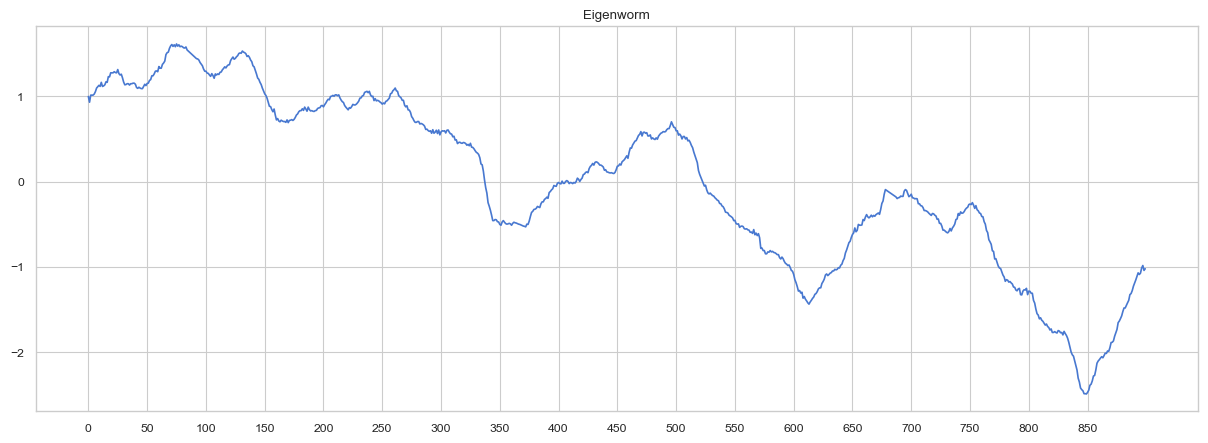

In [8]:
# plot the eigenworm
plt.figure(figsize=(15,5))
plt.plot(range(0, 900), X)
plt.xticks(range(0, 900, 50))
plt.title("Eigenworm")
plt.show()

A first visual inspection of the time series reveals that it does not seem to be stationary.
There is a clear downward trend. As this seems to be linear, we detrend the time series, using SciPy's signal function to be able to see other underlying patterns better.

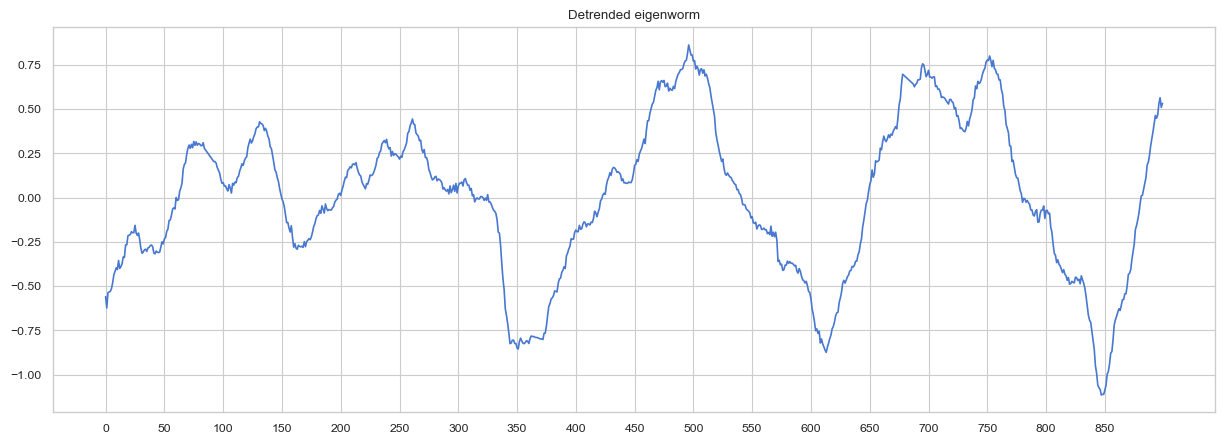

In [9]:
# detrend time series
X_detrended = signal.detrend(X, type='linear')

# plot detrended time series
plt.figure(figsize=(15,5))
plt.plot(range(0, 900), X_detrended)
plt.xticks(range(0, 900, 50))
plt.title("Detrended eigenworm")
plt.show()

The detrended graph still reveals some patterns. On the one hand, there might be seasonality but there does not seem to be a clearly regular pattern and the domain knowledge also does not suggest any obvious seasonality interval. 
Another thing that is obvious is that the change rates increase towards the higher ranges. This is something that should be taken care of when modelling.

## 2. Baseline model for comparison
To check predictive performance of our model, we have to establish a baseline to compare it to. Usually, this entails creating a simple model which is also called naive forecast or persistence. This can then be used to compare how much better our found model is. For this naive forecast we will use a special case of the rolling CV as explained in the second lecture, a walk-forward validation. It entails adding exactly one new datapoint from the test set to the train set for each iteration.
In this naive forecast the prediction for $X_t$ is simply $X_{t-1}$.

In [10]:
# define initial training set at 50% of the data, it will increase over time on a rolling basis
train_size = int(len(X) * 0.50)
X_train, X_test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in X_train]
predictions = list()
for i in range(len(X_test)):
  # predict y as last value
  y_pred = history[-1]
  predictions.append(y_pred)

  # add new observation to history/ train set
  history.append(X_test[i])

# calculate RMSE to check performance of the naive forecast
rmse = mean_squared_error(X_test, predictions, squared=False)
print(f"Naive Forecast RMSE: {rmse}")

Naive Forecast RMSE: 0.03223179653286934


With 0.0322, the RMSE is relatively low. To put it into context of our time series which is normalized, we can see that the forecast is on average 3.22% of a standard deviation off. Next, we plot this naive forecast for visual interpretation.

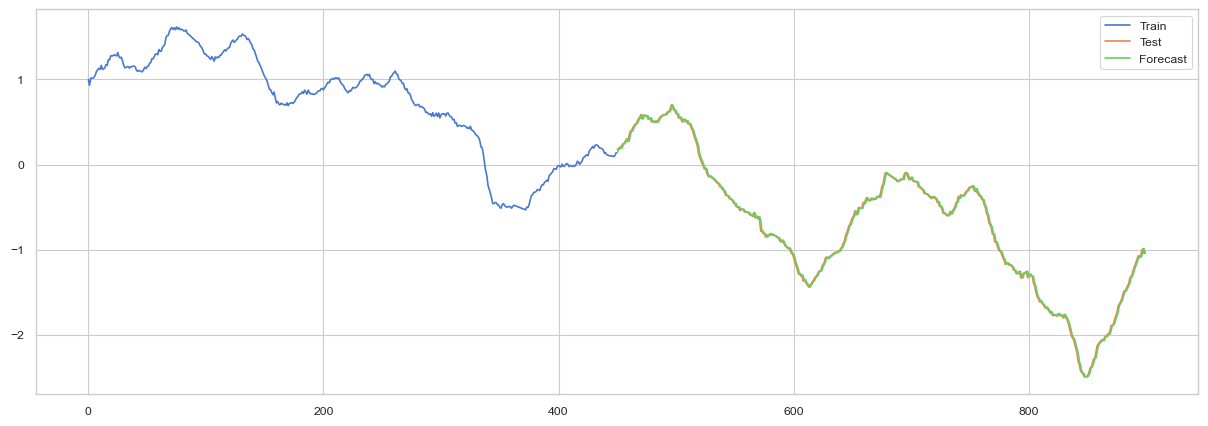

In [11]:
# plot train, test and forecast
plt.figure(figsize=(15,5))
plt.plot(X_train, label='Train')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='Test')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), predictions, label='Forecast')
plt.legend(loc='best')
plt.show()

Now that we have a naive forecast as a baseline, we can proceed with developing a more complex model.

## 3. Check for stationarity
The previous visual inspection in 1 revealed that the eigenworm time series is clearly non stationary. 
Moreover, it exhibits a downward trend. As this trend is linear, we do not need to do anything as differencing to make the time-series stationary will take care of that trend.

We will check for stationarity using the Augmented Dickey-Fuller (ADF) test and visually inspecting the time series differenced at the suggested interval.
In contrast to the normal Dickey-Fuller test, this allows for differencing in the tested underlying equation. The order of the differencing is an indicator for the Autoregressive (AR) component of the time series.

Under ADF, the $H_0$ is that the time series is non-stationary and the $H_A$ is that it's stationary. To ensure stationarity, we have to be able to reject $H_0$ at a common threshold for statistical significance.

From visual inspection, the order of differencing to make the time series stationary is not immediately obvious. Therefore, we will loop through various differences and check their effect on stationarity. It is important to note that higher order differencing considerably reduces the length of the time series which can lead to problems as the amount of information decreases or if the time series is already relatively short in the first place. We will test from 1 to 10 which is already quite extensive

In [12]:
# check for stationarity in the range of 0 to 50
intervals = [i for i in range(1, 11)]

# initialize empty dataframe
df_results = pd.DataFrame(columns=["Interval", "ADF Statistic", "p-value", "1%", "5%", "10%"])

for i in intervals:
  X_difference = difference(X_detrended, i)
  result = adfuller(X_difference)
  df_results.loc[len(df_results)] = [i, result[0], result[1], result[4]["1%"], result[4]["5%"], result[4]["10%"]]

df_results

,Interval,ADF Statistic,p-value,1%,5%,10%
0,1.0,-6.458526,1.462820e-08,-3.437711,-2.864789,-2.568500
1,2.0,-5.031073,1.925603e-05,-3.437820,-2.864837,-2.568526
2,3.0,-4.473523,2.194746e-04,-3.437846,-2.864849,-2.568532
3,4.0,-4.420756,2.727081e-04,-3.437846,-2.864849,-2.568532
4,5.0,-4.348664,3.654824e-04,-3.437854,-2.864853,-2.568534
5,6.0,-4.244223,5.540857e-04,-3.437846,-2.864849,-2.568532
6,7.0,-3.493503,8.155532e-03,-3.437880,-2.864864,-2.568540
7,8.0,-4.374968,3.286196e-04,-3.437871,-2.864860,-2.568538
8,9.0,-3.817250,2.735672e-03,-3.437889,-2.864868,-2.568542
9,10.0,-3.319846,1.401434e-02,-3.437906,-2.864876,-2.568546


It seems that first-differencing is already sufficient to make the time series stationary. Now, let's plot the this time series.

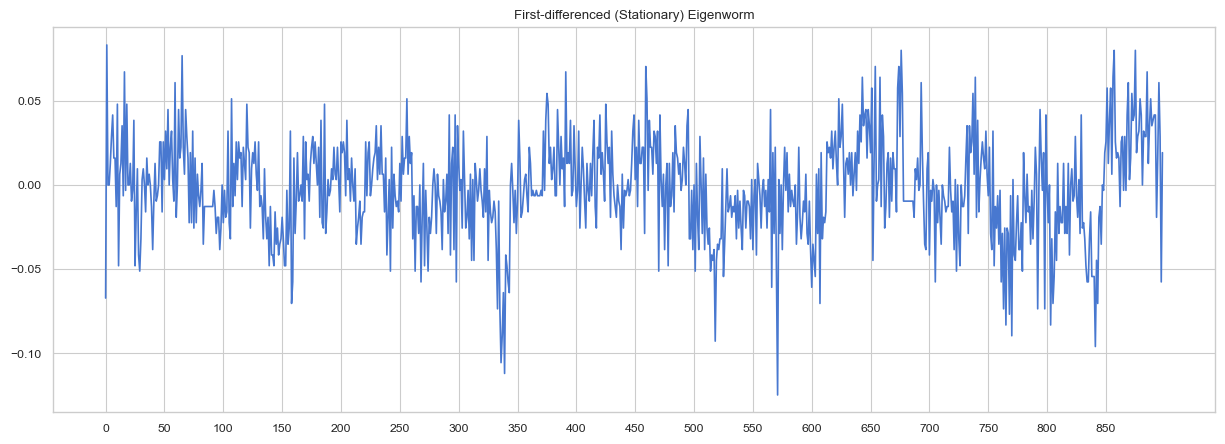

In [13]:
# take first difference
X_difference = difference(X, 1)

# plot the stationary time series
plt.figure(figsize=(15,5))
plt.plot(range(0, 899), X_difference)
plt.xticks(range(0, 900, 50))
plt.title("First-differenced (Stationary) Eigenworm")
plt.show()

As we can see the time series is now stationary and a visual inspection does not reveal any clear patterns. This already covers the *"I"* part of ARIMA as it refers to the order of differencing of the original data. In the $ARIMA(p,d,q)$ notations that means we now know that $d=1$, which leaves $p$ and $q$.

### 3. Inspect the ACF and PACF to determine the Auto-Regressive (AR) and Moving Average (MA) orders of the model

This section aims at determining the order of the AR component of the model $p$ and the MA component of the model $q$. 
1. First, the manual approach entails visually inspecting the ACF and PACF plots first to determine which orders make sense to examine.
2. Second, the automated approach searches a hyperparameter space of $p$ and $q$ to find the best model. This hyperparameter space is also based on the insights obtain during the manual approach.


# !! insert short section on what ACF and PACF do, what Autocorrelation is etc. !!

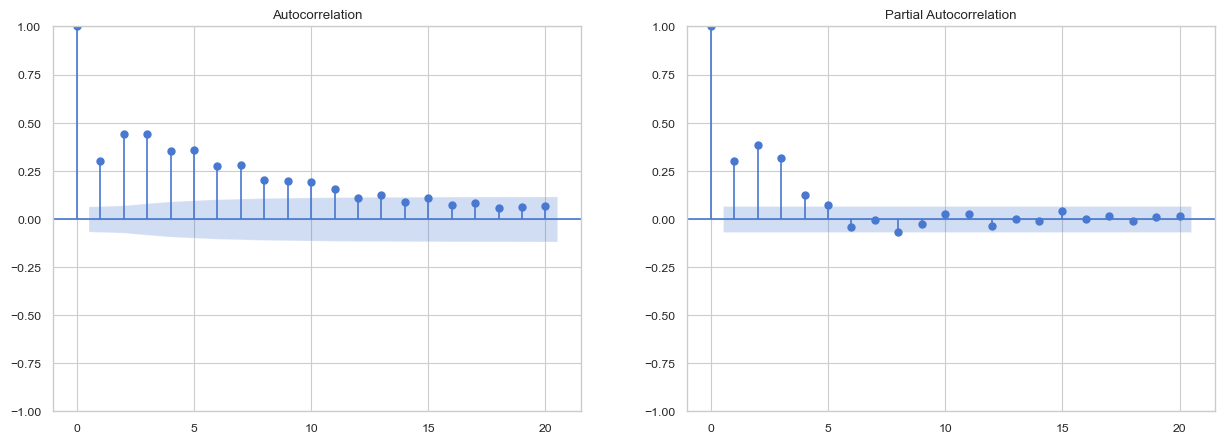

In [14]:
# plot ACF and PACF of the stationary time series in one figure with subplots
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_acf(X_difference, ax=plt.gca(), lags=20)
plt.subplot(1,2,2)
plot_pacf(X_difference, ax=plt.gca(), lags=20)
plt.show()

Both the ACF and the PACF show significant autocorrelations to relatively high degrees. For both, the first lag is slightly lower than the second. We have to keep this fact in mind as it might suggest a mix of an $AR(p)$ and an $MA(q)$ process. 
For now, we observe that the autocorrelations (in the ACF) slowly decrease as the lags increase. This could be considered a "geometric decay".
The partial autocorrelations show a sharp drop after the third lag.

This pattern strongly suggests working with an ARIMA(3,1,0) as a first model.
In the following, we use the same CV procedure as above to arrive at an ARIMA model. We will work with the non-stationary time-series and do the first differencing within the ARIMA model.
Also, we use the "Yule-Walker" estimation method as it's particularly suitable for simple AR models and the standard "statespace" optimizer does not converge for some iterations.

In [15]:
# ARIMA(3,1,0) model
# the data has already been prepared above

# define initial training set at 50% of the data, it will increase over time on a rolling basis
train_size = int(len(X) * 0.50)
X_train, X_test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in X_train]
predictions = list()
for i in range(len(X_test)):
  # initialize ARIMA model and fit on history
  model = ARIMA(history, order=(3,1,0))
  model_fit = model.fit()

  # predict y and add to predictions
  y_pred = model_fit.forecast()[0]
  predictions.append(y_pred)

  # add new observation to history/ train set
  history.append(X_test[i])

# calculate RMSE to check performance of the naive forecast
rmse = mean_squared_error(X_test, predictions, squared=False)
print(f"ARIMA(3,1,0) Forecast RMSE: {rmse}")

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

ARIMA(3,1,0) Forecast RMSE: 0.02641668091397224


The following figure shows the actual eigenworm values over the entire range and the corresponding forecast for the relevant range.

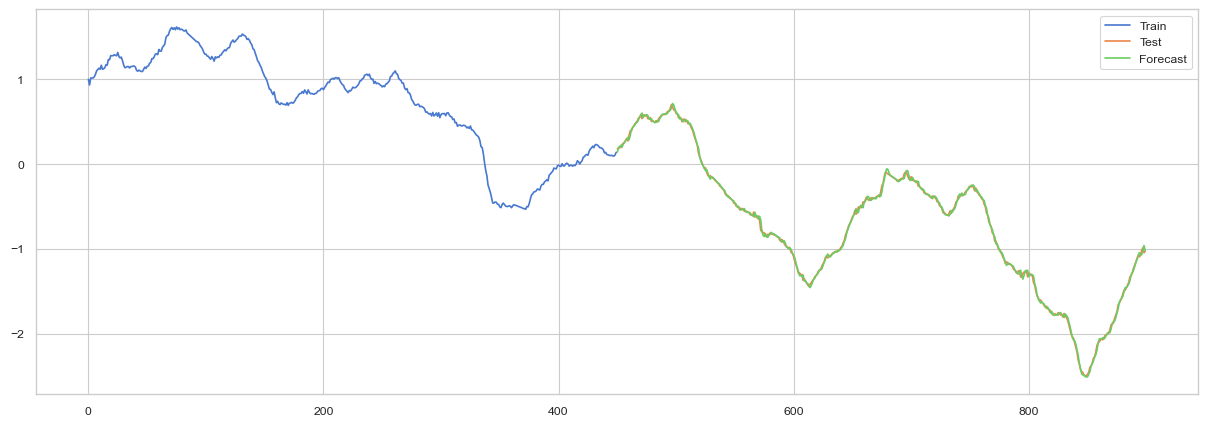

In [16]:
# plot train, test and forecast
plt.figure(figsize=(15,5))
plt.plot(X_train, label='Train')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='Test')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), predictions, label='Forecast')
plt.legend(loc='best')
plt.show()

The following chart displays the forecast and the actual values for the last 100 time points to get a better overview of the data.

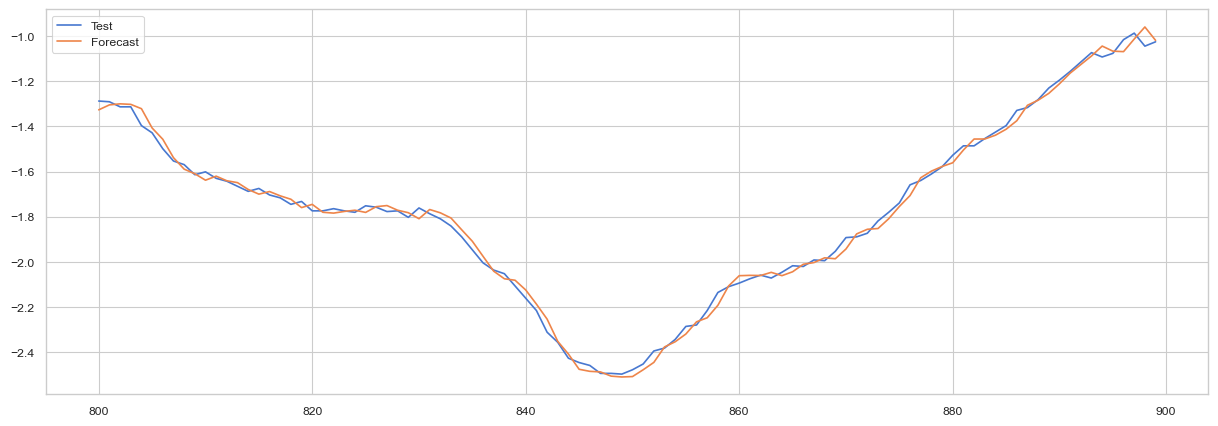

In [17]:
# plot test and forecast
plt.figure(figsize=(15,5))
plt.plot(range(800, 900), X_test[-100:], label='Test')
plt.plot(range(800, 900), predictions[-100:], label='Forecast')
plt.legend(loc='best')
plt.show()

To check whether the model is not predicting with a bias, we now check the residual plot.

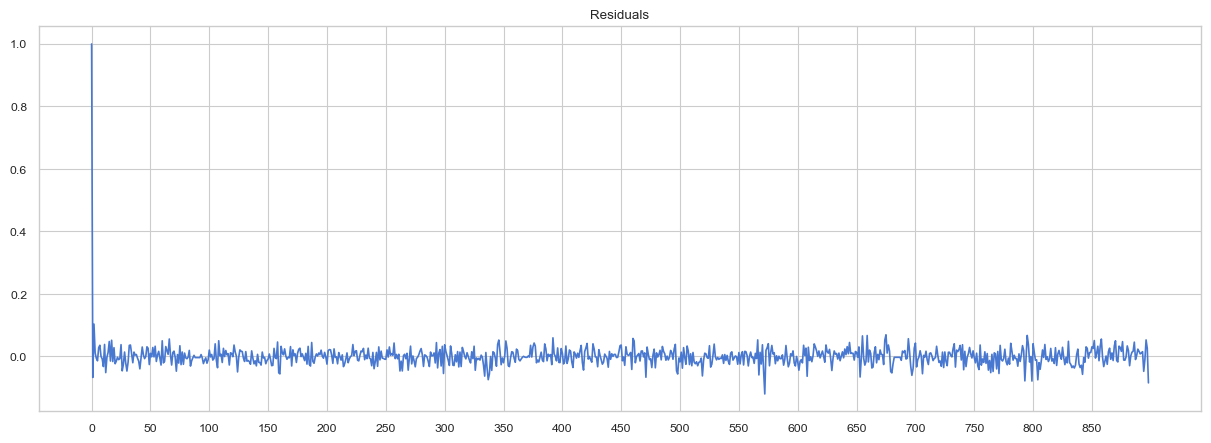

In [18]:
# retrieve the residuals of the model
residuals = pd.DataFrame(model_fit.resid)

# plot the residuals
plt.figure(figsize=(15,5))
plt.plot(range(0, 899), residuals)
plt.xticks(range(0, 900, 50))
plt.title("Residuals")
plt.show()

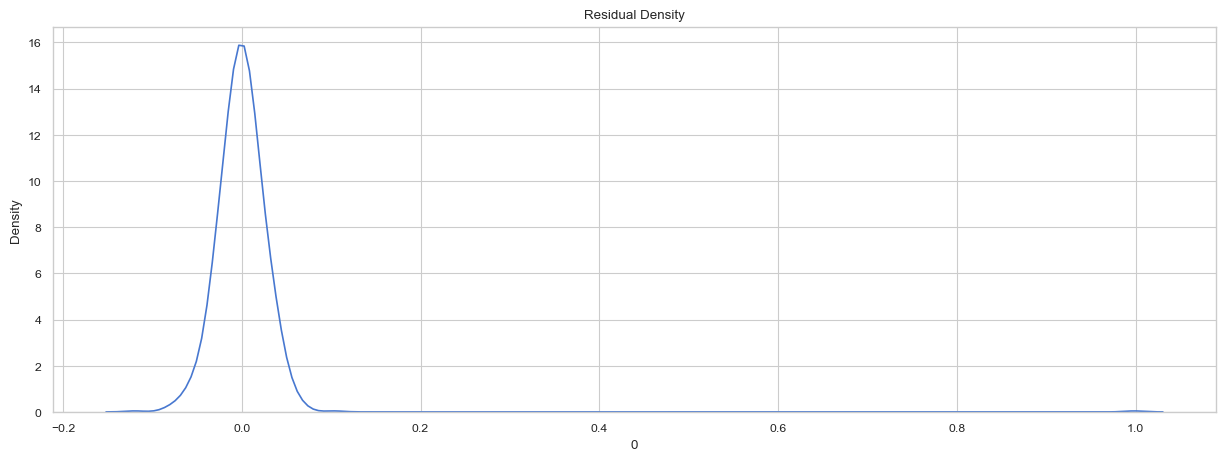

In [19]:
# plot the kde of residual density
plt.figure(figsize=(15,5))
sns.kdeplot(residuals[0])
plt.title("Residual Density")
plt.show()

We would like to have a closer look at the mean of the residuals, so we only plot close to 0.

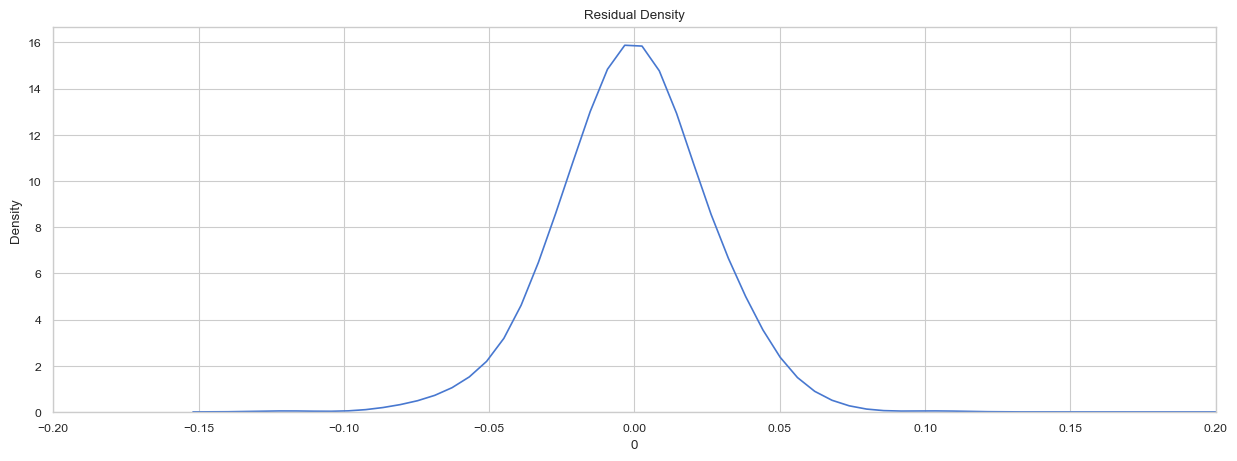

In [20]:
# plot the residual density around 0
plt.figure(figsize=(15,5))
sns.kdeplot(residuals[0])
plt.xlim(-0.2, 0.2)
plt.title("Residual Density")
plt.show()

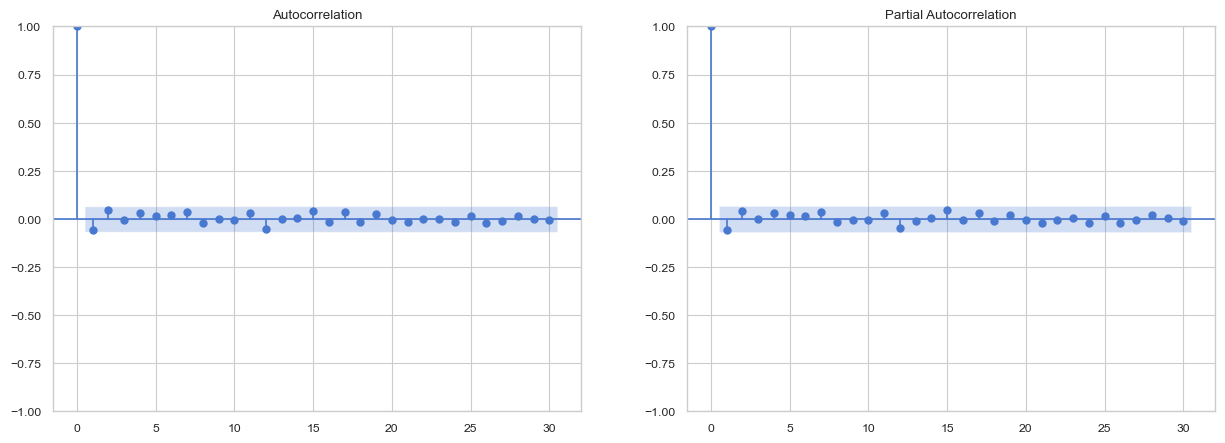

In [21]:
# plot ACF and PACF of the residuals in one figure with subplots
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_acf(residuals, ax=plt.gca(), lags=30)
plt.subplot(1,2,2)
plot_pacf(residuals, ax=plt.gca(), lags=30)
plt.show()

The residuals show no autocorrelation or partial-autocorrelation.
The visual inspection of the residuals reveals that the model does not seem to have a bias.

The manual process for estimating an ARIMA model reveals that an AR(3) process with first-order differencing seems to do a good job at predicting the time series at hand. Given that this is still a fairly easy model and that we were able to improve the RMSE from the Naive Forecast by 18% from 0.0322 to 0.0264, we could use this process to model the series and use it for forecasting.

### Grid-search ARIMA

In [23]:
# implement grid-search

# make lists of p and q
ps = [x for x in range(0, 6)]
qs = [x for x in range(0, 6)]

# set difference to 1
d = 1

# initialize empty dataframe
df_results = pd.DataFrame(columns=["p", "d", "q", "RMSE"])

# loop over p and q
for p in ps:
    for q in qs:
        # set initial train and test set
        train_size = int(len(X) * 0.50)
        X_train, X_test = X[0:train_size], X[train_size:]

        # walk-forward validation
        history = [x for x in X_train]
        predictions = list()

        # run model
        for i in range(len(X_test)):
            # initialize ARIMA model and fit on history
            model = ARIMA(history, order=(p,d,q))
            model_fit = model.fit(method_kwargs={'warn_convergence': False})

            # predict y and add to predictions
            y_pred = model_fit.forecast()[0]
            predictions.append(y_pred)

            # add new observation to history/ train set
            history.append(X_test[i])

        # calculate RMSE of this model
        rmse = mean_squared_error(X_test, predictions, squared=False)  

        # add results to dataframe
        df_results.loc[len(df_results)] = [p, d, q, rmse]

# print results
df_results.sort_values(by="RMSE", ascending=True, inplace=True)
display(df_results)


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

,p,d,q,RMSE
15,2.0,1.0,3.0,0.026164
21,3.0,1.0,3.0,0.026178
27,4.0,1.0,3.0,0.026178
16,2.0,1.0,4.0,0.026188
33,5.0,1.0,3.0,0.026189
29,4.0,1.0,5.0,0.026197
30,5.0,1.0,0.0,0.026219
31,5.0,1.0,1.0,0.026220
8,1.0,1.0,2.0,0.026229
17,2.0,1.0,5.0,0.026233
